In [1]:
import pandas as pd
import numpy as np
from random import randint
from pandas import Series,DataFrame
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import math
%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['font.size'] = 14

In [72]:
%%html
<style>
table {float:left}
</style>

Using the MNIST digit dataset.

Source: http://yann.lecun.com/exdb/mnist/

sklearn has nicely [imported](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html#sklearn.datasets.load_digits) it for us.

| Classes           | 10            |
|-------------------|---------------|
| Samples per class | ~180          |
| Samples total     | 1797          |
| Dimensionality    | 64            |
| Features          | integers 0-16 |

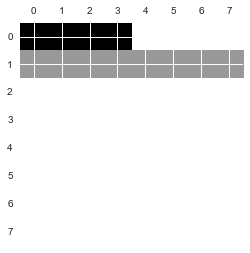

In [106]:
test_image = np.zeros((8,8))
test_image[0,:4] = 256
test_image[1,] = 125
plt.matshow(test_image)

<class 'sklearn.datasets.base.Bunch'>
[1775, 1248, 1373, 817, 839, 183, 1406, 1627, 1766, 39]


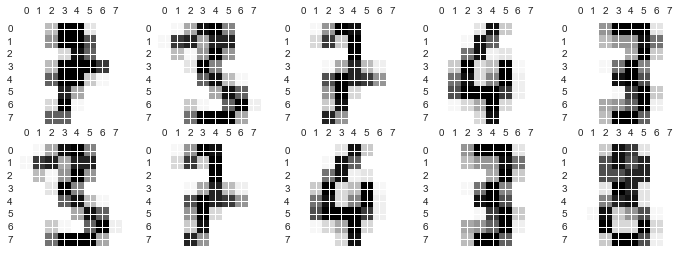

In [3]:
from sklearn.datasets import load_digits
digits = load_digits(n_class=10)
print type(digits)

import random
digits_sample = random.sample(range(0,digits.images.shape[0]),10)
print digits_sample

#show sample digits
plt.rcParams['figure.figsize'] = (12, 4)
f, axarr = plt.subplots(2, 5)
for j in range(0,axarr.shape[1]):
    for i in range(0,axarr.shape[0]):
        axarr[i,j].matshow(digits.images[digits_sample[i+j]])
plt.show()

Multi Layer Feed-Forward Neural Network (in this case, 3 layers [input, 1 hidden, output])

Source: https://en.wikipedia.org/wiki/Feedforward_neural_network

Source2: http://neuralnetworksanddeeplearning.com/chap1.html

The structure is something like the below.

In our case, each image have a total of 8x8 = 64 pixels, so using 64 input neurons instead.
We can try using 15 hidden neurons.

<img src="http://neuralnetworksanddeeplearning.com/images/tikz12.png" style="width:500px;" />

Let's define some terms.

| symbol       | meaning                                           |
|--------------|---------------------------------------------------|
| i            | index of input to the neurons                     |
| k            | index of the neurons (per layer)                  |
| j            | index of data input rows (each digit image)       |
| w            | weight vector for neuron connections              |
| $w_{i,k}$    | weight connection from i input to k neuron        |
| x or X       | vector or array of input data                     |
| y or Y       | vector or array of target result (0 or 1)         |
| f or f(x,..) | activation function, in this case it's a sigmoid. |
| $\eta$       | learning rate. (pronouce:"eta")                   |


10-digit multi-classification where probability for each digit's prediction node is

$$ f(w,X) = \dfrac{1}{1+e^{-(w \cdot X)}} $$

(Note: the weight vector "w" includes bias component as $w_0$. X will always have first input as a "1", so bias is always there.)


##### Loss function:

Loss function is a mean-square error(MSE).

$$ L = \dfrac{1}{2m}\sum_{j=1}^m \bigl\|\;f(w,x_j) - y_j\;\bigr\|^2 $$

The first [partial derivative](https://www.cs.swarthmore.edu/~meeden/cs81/s10/BackPropDeriv.pdf) is the gradient, in simplified term is:

$$ \Delta w_{i,k,j} = - (y_k-f_{k,j}) \cdot f_{k,j} \cdot (1-f_{k,j}) \cdot x_{i,j}$$

$$ \Delta w_{i,k} = - \dfrac{1}{m} \sum_{j=1}^m  (y_k-f_{k,j}) \cdot f_{k,j} \cdot (1-f_{k,j}) \cdot x_{i,j}$$

In shorter form, we group the inner part under a new variable "delta":

$$ \Delta w_{i,k} = - \dfrac{1}{m} \sum_{j=1}^m  \delta_{k,j} \cdot x_{i,j}$$

Then we can update the w (with learning rate)

$$ w_{i,k}(t+1) = w_{i,k}(t) - \dfrac{\eta}{m}\sum_{j=1}^m  \delta_{k,j} \cdot x_{i,j}$$

Specifically, for the weights from hidden to output layer ($w^{out}$). The input "$x$" is actually the result from the lower layer $f^{hid}$.

##### w hidden-to-output layer update:

$$ w_{i,k}^{out}(t+1) = w_{i,k}^{out}(t) - \dfrac{\eta}{m}\sum_{j=1}^m  \delta_{k,j}^{out} \cdot f_{i,k}^{hid}$$


Moving on to the lower layer -- from input to hidden. 

Here comes the [backpropagation](https://www.cs.swarthmore.edu/~meeden/cs81/s10/BackPropDeriv.pdf) --summing back from the higher layer:

$$ \Delta w_{i,k}^{hid} = -\dfrac{1}{m} \sum_{j=1}^m \bigl\{ \bigl(\sum_{k_{out}=1}^n  \delta_{k_{out},j}^{out} \cdot w_{k_{hid},k_{out}}^{out}(t) \bigr) \cdot f_{k,j}^{hid} \cdot (1-f_{k,j}^{hid}) \cdot x_{i,j} \bigr\}$$

Again, we can shorten it to:

$$ \Delta w_{i,k}^{hid} = -\dfrac{1}{m} \sum_{j=1}^m \delta_{k,j}^{hid} \cdot x_{i,j} $$

And we can update w as such:

##### w input-to-hidden layer update:

$$ w_i^{hid}(t+1) = w_i^{hid}(t) - \dfrac{\eta}{m}\sum_{j=1}^m  \delta_{i,j}^{hid} \cdot x_{i,j}$$

For step-by-step calculation, [this](https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/) is a really good writeup.

---

#### Optimization method

We will use "mini-batch stochastic gradient descent"

mini-batch & stochastic means we will sample n datapoints and compute an aggregate gradient to update the weights.



In [773]:
#set size of input, features, hidden, target
sample_size = digits.images.shape[0]
feature_size = digits.images.shape[1]*digits.images.shape[2]
target_size = 10
hidden_size = 15

#make a flat 10 output with all zeros
Y = np.zeros((sample_size,10))
for j in range(0,sample_size):
    Y[j][digits.target[j]] = 1

#make a row of 64 input features instead of 8x8
X = digits.images.reshape(sample_size,feature_size)
Xb = np.insert(X,0,1,axis=1) #add bias input, always activated

In [774]:
def sigmoid(w,X):
    a = 1.0/(1.0 + np.exp(-w.dot(X.transpose())))
    return a.transpose()

def loss_func(Y,y_pred):
    return 0.5*np.average((Y-y_pred)**2) #element-wise operation then aggregate

In [775]:
#initialize the rest of the terms
# for weights --> index = (output node , input node)
w_hid = np.full((hidden_size,feature_size+1),0.1) #don't forget the bias
w_out = np.full((target_size,hidden_size+1,),0.1) #don't forget the bias

#for f --> index = (data row , node)
f_hid = np.zeros((sample_size,hidden_size))
f_out = np.zeros((sample_size,target_size))

#for deltas  --> index = (data row , node)
delta_hid = np.zeros((sample_size,hidden_size))
delta_out = np.zeros((sample_size,target_size))

In [784]:
#verification with dummy data
#checking numbers from https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
sample_size = 1
X = np.array([[0.05,0.1]])
Xb = np.array([[1, 0.05,0.1]])
Y = np.array([0.01,0.99])
w_hid = np.array([[0.35,0.15,0.20],[0.35,0.25,0.3]])
w_out = np.array([[0.60,0.40,0.45],[0.60,0.50,0.55]])
w_out_bef = w_out.copy()

start_loss = 0.00278056022735


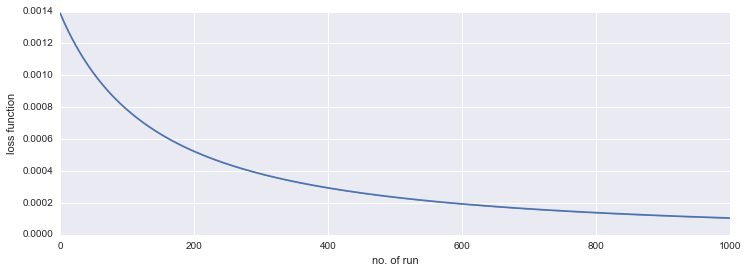

In [789]:
#run configuration
max_epoch = 1000
min_loss_criterion = -10**-5

#doing 1st forward pass to calculate loss
f_hid = sigmoid(w_hid,Xb)
f_hid_b = np.insert(f_hid,0,1,axis=1) #bias activation for next layer
#print 'f_hid_b = '
#print f_hid_b
#print 'w_out = '
#print w_out
f_out = sigmoid(w_out,f_hid_b)
#print f_out
curr_loss = loss_func(Y,f_out)
loss = []
loss.append(curr_loss)
print 'start_loss = {}'.format(curr_loss*2)

learning_rate = 0.5
learning_rate_bias = 0.5

for i in range(0,max_epoch):
    #update the weights of output layer
    delta_out = (f_out - Y)*(f_out)*(1-f_out) #element-wise operation 
    #print 'delta_out = ',
    #print delta_out[0:4]
    #print 'f_hid = ',
    #print f_hid[0:4]
    wgrad_out = (1.0/sample_size)*(delta_out.T).dot(f_hid) #dot operation already sums it up
    #print 'wgrad_out = '
    #print wgrad_out[0:3]
    #print 'w_out_before = '
    #print w_out[0:3]
    w_out_bef = w_out.copy()
    w_out[:,1:] = w_out[:,1:] -learning_rate*(wgrad_out)
    w_out[:,0] = w_out[:,0] -learning_rate_bias*(1.0/sample_size)*np.sum(delta_out,axis=0)*1.0
    #print 'w_out_after = '
    #print w_out
    #print '---'

    #update the weights of hidden layer
    #print 'f_hid = '
    #print f_hid 
    #print 't1 = '
    #print delta_out.dot(w_out_bef[:,1:])
    #print 't2 = '
    #print (f_hid)*(1-f_hid)
    delta_hid = delta_out.dot(w_out_bef[:,1:])*(f_hid)*(1-f_hid) #dot then element-wise operation 
    #print 'delta_hid = '
    #print delta_hid
    #print 'Xb = '
    #print Xb
    wgrad_hid = (1.0/sample_size)*delta_hid.transpose().dot(Xb)
    #print 'wgrad_hid = '
    #print wgrad_hid
    w_hid = w_hid -learning_rate*wgrad_hid
    #print 'w_hid = '
    #print w_hid
    
    #re-calculate loss
    f_hid = sigmoid(w_hid,Xb)
    f_hid_b = np.insert(f_hid,0,1,axis=1) #bias activation for next layer
    f_out = sigmoid(w_out,f_hid_b)
    curr_loss = loss_func(Y,f_out)
    loss.append(curr_loss)

    #stopping criterion
    if (i>10) and ((loss[-2] - curr_loss) < min_loss_criterion): 
        print 'stop at {}'.format(i)
        break

plt.figure()
plt.xlabel('no. of run')
plt.ylabel('loss function')
sns.tsplot(loss)

In [790]:
print f_out[0:4]
y_pred = np.argmax(f_out,axis=1)
print y_pred[0:4]
print digits.target[0:4]

[[ 0.02472794  0.97574449]]
[1]
[0 1 2 3]


In [791]:
#get the prediction to compare with target
y_pred = np.argmax(f_out,axis=1)

from sklearn.metrics import confusion_matrix
cm_mat = confusion_matrix(digits.target,y_pred)
print cm_mat.T
df_temp = pd.DataFrame(cm_mat.flatten()[np.newaxis].T,columns = ['values'])
plt.figure(figsize = (6,4),dpi=600)
sns.heatmap(cm_mat.T, cbar=True ,annot=True, fmt=',.0f')
plt.xlabel('Truth')
plt.ylabel('Predicted')

ValueError: Found arrays with inconsistent numbers of samples: [   1 1797]

In [157]:
t1 = np.array([[3,4,5],[6,7,8]])
t2 = np.array([[1,1,1],[4,5,6]])
(t1-t2)**2

array([[ 4,  9, 16],
       [ 4,  4,  4]])

In [4]:
def f_func(w,x):
    result = w.dot(x.transpose())
    return np.where(result>0,1,0)

def loss_func(f,y):
    return np.average(np.abs(f - y))

In [5]:
#initialize everything.
w = np.array([0.01 , 0.01, 0.01]) # including bias as weight (w0 in the first column)
Xb = np.insert(X,0,1,axis=1) #add bias input, always activated

#run till convergence
y_pred = f_func(w,Xb)
curr_loss = loss_func(y_pred,Y)
loss = []
loss.append(curr_loss)

for i in range(0,100):
    
    #iterate over each j input vector
    for j in range(0,Y.shape[0]): 
        y_pred[j] = f_func(w,Xb[j])
        w = w + (Y[j] - y_pred[j])*Xb[j]
    
    #evaluate aggregate loss function    
    y_pred = f_func(w,Xb)
    curr_loss = loss_func(y_pred,Y)
    loss.append(curr_loss)
    
    #stopping criterion
    if (i>10) and ((loss[-2] - curr_loss) < 10**-5): 
        print 'stop at {}'.format(i)
        break

print w
plt.figure()
plt.xlabel('no. of run')
plt.ylabel('loss function')
plt.title('Loss function minimization over time')
sns.tsplot(loss)

NameError: name 'X' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix
cm_mat = confusion_matrix(Y,y_pred)
print cm_mat.T
df_temp = pd.DataFrame(cm_mat.flatten()[np.newaxis].T,columns = ['values'])
plt.figure(figsize = (6,4),dpi=600)
sns.heatmap(cm_mat.T, cbar=True ,annot=True, fmt=',.0f')
plt.xlabel('Truth')
plt.ylabel('Predicted')
plt.title('confusion matrix')

In [ ]:
#plot decision boundary

plt.scatter(X[:, 0], X[:, 1], marker='o', c=Y)

x_line = np.array([np.min(X[:, 0]),np.max(X[:, 0])]) #this is "x0"
y_line = -(w[0] + w[1]*x_line)/w[2] #plot y_line based on where it makes "x1" becomes zero
plt.plot(x_line,y_line)
plt.show()
print y_line